In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [3]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [4]:
train ={ 2: {
          'start_time': "2011-04-21" ,
          'end_time': "2011-05-21"
    }
   ,
     3: {
          'start_time': "2011-04-19" ,
          'end_time': "2011-05-22"
    }
}
test = {  1: {
          'start_time': "2011-04-28" ,
          'end_time': "2011-05-15"
        } 
   
      
}
appliances = ["Dish Washer"]

In [5]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler


def dataset_load(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    n = 9
    units_to_pad = n // 2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    # train
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_train.extend(x)
        y_train.extend(y)
        x_train_timestamp.extend(torch.Tensor(timestamp_train))


    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.Tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)


    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_test.extend(x)
        y_test.extend(y)
        x_test_timestamp.extend(timestamp)

    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.Tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
#     y_test = scaler_y.transform(y_test)

    x_train = jnp.array(x_train).reshape(x_train.shape[0], n)
    y_train = jnp.array(y_train)
    x_train_timestamp = torch.Tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test).reshape(x_test.shape[0], n)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.Tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1)

    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time


In [6]:
x_train, y_train, x_test, y_test, x_train_timstamp, x_test_timestamp, scaler_x, scaler_y,scaler_time= dataset_load(appliances, train, test)

In [7]:
# indexes =15000
n = 9
# x_train_full = jnp.concatenate((jnp.array(x_train.reshape(-1,n)), jnp.array(np.array(x_train_timstamp))), axis=1)
# x_test_full = jnp.concatenate((jnp.array(x_test.reshape(-1,n)), jnp.array(np.array(x_test_timestamp))), axis=1)
# x_train_full.shape, x_test_full.shape

x = torch.Tensor(np.array(x_train))
y = torch.Tensor(np.array(y_train)).reshape(-1)
xt = torch.Tensor(np.array(x_test))
yt = torch.Tensor(np.array(y_test)).reshape(-1)

# if x.shape[0]>indexes:
#   x1 = x[:indexes]
#   y1 = y[:indexes]

# xt1= x[indexes:]
# yt1 = y[indexes:]

In [8]:
x.shape, xt.shape

(torch.Size([30436, 9]), torch.Size([10138, 9]))

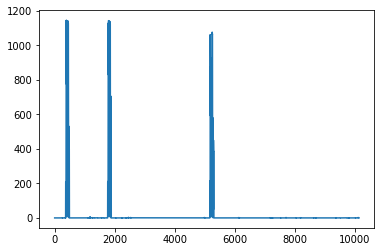

In [9]:
plt.plot(yt)

In [10]:
data_dim = x.size(-1)
class LargeFeatureExtractor1(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor1, self).__init__()
        self.add_module('lstm', torch.nn.LSTM(data_dim, 256,4))
        # self.add_module('linear1', torch.nn.Linear(data_dim, 250))
        # self.add_module('relu1', torch.nn.ReLU())
        # self.add_module('linear2', torch.nn.Linear(250, 50))     
        # self.add_module('relu2', torch.nn.ReLU())                  
        # self.add_module('linear3', torch.nn.Linear(50, 9))       
        # self.add_module('relu3', torch.nn.ReLU())   
        # self.add_module('linear4', torch.nn.Linear(250, 100))       
        # self.add_module('relu4', torch.nn.ReLU())                         
        # self.add_module('linear5', torch.nn.Linear(100, 9))

class LargeFeatureExtractor2(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor2, self).__init__()
        # self.add_module('lstm', torch.nn.LSTM(data_dim, 500,2))
        # self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        # self.add_module('relu1', torch.nn.ReLU())
        # self.add_module('linear2', torch.nn.Linear(1000, 500))     
        # self.add_module('relu2', torch.nn.ReLU())                  
        self.add_module('linear1', torch.nn.Linear(256, 64))       
        self.add_module('relu1', torch.nn.ReLU())   
        self.add_module('linear2', torch.nn.Linear(64, 9))                          
        # self.add_module('linear1', torch.nn.Linear(200, 99))  

feature_extractor1 = LargeFeatureExtractor1().cuda()
feature_extractor2 = LargeFeatureExtractor2().cuda()

In [11]:
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.base_covar_module =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=9)) 
            #+ gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=(49)))*gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(ard_num_dims=1, active_dims=(49)))
            # self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            #     gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
            #     num_dims=2, grid_size=100
            # )
            self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[np.arange(0, train_x.shape[0], 25)], likelihood=likelihood)
            print(self.covar_module)
            self.feature_extractor1 = feature_extractor1
            self.feature_extractor2 = feature_extractor2

            # This module will scale the NN features so that they're nice values
            # self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x, (hn,cn) = self.feature_extractor1(x)
            print(projected_x.shape, hn.shape,cn.shape)
            projected_x = self.feature_extractor2(projected_x)
            # print(projected_x.shape, hn.shape,cn.shape)
            # projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1
            # print(projected_x.dtype)
            mean_x = self.mean_module(projected_x) #projected_
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [12]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(x, y, likelihood)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

InducingPointKernel(
  (base_kernel): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
)


In [13]:
import tqdm
training_iterations = 300

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
loss_arr =[]
def train():
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(x.cuda())
        # Calc loss and backprop derivatives
        loss = -mll(output, y.cuda())
        # loss_arr.append(loss.cpu())
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()

%time train()

  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])


/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_sol

torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])


/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 2

KeyboardInterrupt: 

In [14]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(xt.cuda())

torch.Size([30436, 256]) torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([40574, 256]) torch.Size([4, 256]) torch.Size([4, 256])


In [15]:
print('Test MAE: {}'.format(torch.mean(torch.abs(torch.tensor(scaler_y.inverse_transform(preds.mean.cpu().reshape(-1,1)).squeeze()) - yt))))

Test MAE: 24.752034248907492


In [ ]:
#Test MAE: 26.224479548161128 build3
#Test MAE: 9.841791420581126 build2
#Test MAE: 24.752034248907492 build1